# CSE 152A Winter 2025 – Assignment 3

- Assignment Published On: **Wednesday, February 19, 2025**

- Due On: **Saturday, March 1, 2025 11:59 PM (Pacific Time)**

## Instructions

Please answer the questions below using Python in the attached Jupyter notebook and follow the guidelines below:
 
- This assignment must be completed **individually**. For more details, please follow the Academic Integrity Policy and Collaboration Policy posted on lecture slides.

- All the solutions must be written in this Jupyter notebook.

- After finishing the assignment in the notebook, please export the notebook as a PDF and submit both the notebook and the PDF (i.e. the `.ipynb` and the `.pdf` files) on Gradescope. (Note: Please ensure that all images/plots are clear in the pdf).

- You may use basic algebra packages (e.g. `NumPy`, `SciPy`, etc) but you are not allowed to use open source codes that directly solve the problems. Feel free to ask the instructor and the teaching assistants if you are unsure about the packages to use.

- It is highly recommended that you begin working on this assignment early.

- Make sure that you read hints for questions (wherever given).

**Late Policy:** Assignments submitted late will receive a 25% grade reduction for each 12 hours late (that is, 50% per day).

## Submission Instructions

- You must submit both the `.ipynb` file and a `.pdf` version of your notebook.

- Some methods to generate PDF
    -  File -> Save and Export Notebook As -> `.html` -> Print -> Save as PDF
    -  Using [nbconvert](https://nbconvert.readthedocs.io/en/latest/)


- We will be grading primarily from your notebook.
    - It is your responsibility to make sure that your code and outputs are visible.
 
## Virtual Environment

### Initial Set-up
You can utilize a virtual environment (`venv`) in order to manage dependencies: [venv link](https://docs.python.org/3/library/venv.html) along with the libraries specified in `requirements.txt`.

To create the environment:
```
python -m venv cse152a_hw3
```

To activate the environment (Mac/Linux):
```
source ./cse152a_hw3/bin/activate
```

To activate the environment (Windows):
```
.\cse152a_hw3\Scripts\activate
```

Once the virtual environment is activated, you can install the libraries according to `requirements.txt` like so:
```
pip install -r requirements.txt
```

You should then add the environment to jupyter notebook like so:
```
python -m ipykernel install --user --name=cse152a_hw3
```

To deactivate the environment, simply:
```
deactivate
```

This assumes you have Python installed already.

### Using the venv
Once you've installed all the requirements within the venv, you can deactivate and would no longer need to repeat the above steps. You can simply open a Jupyter instance.

Opening a Jupyter instance:
```
jupyter-lab
```

Ensure that you select the correct kernel (named `cse152a_hw3` if you followed the steps above) by clicking Kernel -> Change Kernel.

In [21]:
# Run this cell to check that all libraries are installed
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

## Problem 1: Image Classiﬁcation Using Bag-of-words [20 pts]

We will now build a binary classifier to determine whether an input image contains an image with a human face or not (nonface). A training dataset has been provided consisting of images of human faces and other random objects (nonfaces). You are highly encouraged to look at the images yourself to get a feel for the data and the overall problem we will be working on. We will build a visual bag-of-words representation for images and build K-nearest neighbor classifier.

## Review of bag-of-words for image classification

We will attempt to solve image classification with the relatively simple but effective visual bag-of-words approach. We treat an image as a set of regions and ignore the spatial relationships between different regions. The image classification problem can then be solved by counting the frequencies of different regions appearing in an image. Image classification using bag-of-words includes the following steps: 

- **Feature Detection**: First, we need to perform feature detection to find interest points within our image to build our features descriptors around. Feature detection methods could be corner detection like you implemented in HW2 for example. In this assignment, you will be implementing a random sampler (uniformly sampling points from grids placed across the image). We've also implemented a SIFT keypoint feature detector to compare.

- **Feature Extraction**: Second, we extract descriptors from our selected interest points. One commonly used feature descriptor are SIFT descriptors -- which has also been implemented for you to compare. We will extract features from every image in the training set. You will be implementing patch feature descriptors which simply means to flatten a window around the interest point. These features are collected to compute the visual vocabulary.

- **Building visual vocabulary**: Once we have the features extracted from training images, we build a visual vocabulary by grouping them together to form clusters. We will use the k-means algorithm to group the features. Each cluster will be a visual "word" in our vocabulary. One reason why we need this step is to reduce the feature space and build a concise feature representation of images.

- **Learning and recognition**: Given the visual vocabulary, each training image is represented by a histogram, where the features in the image populate bins that correspond to the visual word closest to them. Thereafter, we will use k-nearest neighbors to perform classification for a test image, also represented by a histogram using the same vocabulary.

## Data Preprocessing
Below is some code used to load and process the data. We will build a classifier to predict whether an image is of a human face or not (nonface). The dataset contains 100 images with faces and 100 images without faces. We will pick 75 images from each group for training and use the other 25 from each for testing. Here, we denote faces as the "positive class" and nonfaces as the "negative class".

In [22]:
# Data Paths and Setup Parameters
pos_data = "images/face/"
neg_data = "images/nonface/"
train_ratio = 0.75
im_size = (133, 200) # Resize each image to this size
random.seed(1234)

def list_image(data_root):
    file_list = glob.glob(str(f"{data_root}*.jpg"))
    im_num = len(file_list)
    file_list = [file_list[i].replace('\\', '/') for i in range(im_num)]
    return file_list

def load_image(img_name, im_size):
    # load the image, resize, and convert from color to grayscale
    img = cv2.imread(img_name)
    img = cv2.resize(img, (im_size[1], im_size[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = img / 255.0 # Convert image range from [0,255] to [0.0, 1.0]
    return img

def create_split(img_list, ratio):
    random.shuffle(img_list)
    train_list = img_list[:round(len(img_list)*ratio)]
    test_list = img_list[round(len(img_list)*ratio):]
    return train_list, test_list

# Data Preprocessing -- Load images and create training/testing splits
pos_list = list_image(pos_data)
neg_list = list_image(neg_data)
train_pos_list, test_pos_list = create_split(pos_list, train_ratio)
train_neg_list, test_neg_list = create_split(neg_list, train_ratio)
train_list = train_pos_list + train_neg_list # Concatenate both positive and negative training data
test_list = test_pos_list + test_neg_list
# Build our labels: 1 for face (positive), 0 for nonface (negative)
train_label = np.concatenate((np.ones(len(train_pos_list)), np.zeros(len(train_neg_list))))
test_label = np.concatenate((np.ones(len(test_pos_list)), np.zeros(len(test_neg_list))))

Text(0.5, 1.0, 'Sampled Negative Image')

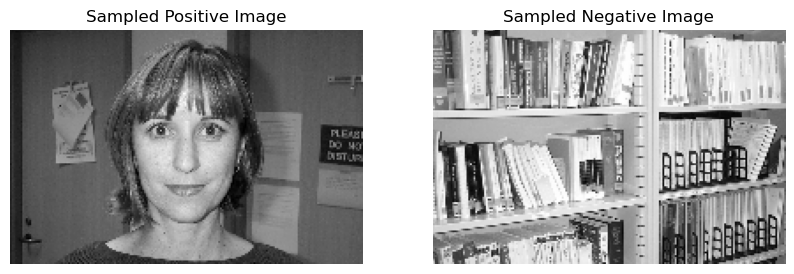

In [23]:
# This is used to plot a training example from both the positive and negative training set
sample_pos = load_image(pos_list[0], im_size)
sample_neg = load_image(neg_list[0], im_size)
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(sample_pos, cmap="gray")#, vmin=0.0, vmax=1.0)
axes[0].axis("off")
axes[0].set_title("Sampled Positive Image")
axes[1].imshow(sample_neg, cmap="gray")#, vmin=0.0, vmax=1.0)
axes[1].axis("off")
axes[1].set_title("Sampled Negative Image")

## 1.1 Extract interest points from images [2 pts]

You will now try two methods for this: 

- **(a) Uniformly sample the images:** You can divide the image into regular grids (chosen by the `w_grid` parameter), choose a random point in each grid uniformly and then randomly choose at maximum `n_pts` number of interest points (it's OK if your image ends up having less). If you cannot fit an entire grid (i.e. at right and bottom edges), then you can simply just ignore those grids in your algorithm.
- **(b) Sample using SIFT keypoint detector:** This is already implemented for you. First, we use the SIFT keypoint detector to detect interest points within the image and then choose `n_pts` number of the detected interest points. We will compare this approach to approach (a) at the end.

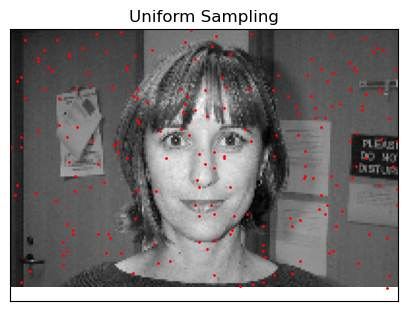

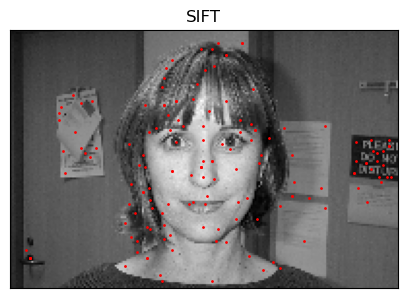

In [24]:
# Parameters used for (1.1) -- DO NOT CHANGE
n_pts = 200 # Number of points to be sampled
w_grid = 5 # Width of the grid used for uniform sampling

def uniform_sampling(im_size, n_pts, w_grid):
    """
    Divide the image into grids and then randomly sample each grid uniformly.
    Afterwards, randomly sample up to `n_pts` of them.
    Note: we don't need the image itself, just the size to perform this.
    Args:
        im_size: size of images (height, width)
        n_pts: maximum number of interest points to be extracted
        w_grid: the width of the small grids
    Return:
        pts: a list of interest points [(x_0, y_0),...,(x_n, y_n)]
    """

    """ YOUR CODE HERE """
    pts = []
    h, w = im_size  
    for i in range(0, h, w_grid):
        for j in range(0, w, w_grid):
            x = random.randint(i, min(i+w_grid, h))
            y = random.randint(j, min(j+w_grid, w))
            pts.append((y, x))
        """ END YOUR CODE """
    return random.sample(pts, n_pts)
def sift_keypoint_sampling(img, n_pts):
    """
    Uses SIFT keypoint detector to extract interest points.
    Args:
        img: image from which you want to extract the interest points
        n_pts: maximum number of interest points to be extracted
    Return:
        pts: a list of interest points [(x_0, y_0),...,(x_n, y_n)]
    """
    sift = cv2.SIFT_create(n_pts)
    keypoints = list(sift.detect(img, None))
    random.shuffle(keypoints)
    # keypoints = sorted(keypoints, key=lambda kp: kp.response, reverse=True)[:n_pts]
    keypoints = keypoints[:n_pts]
    pts = [(int(kp.pt[0]), int(kp.pt[1])) for kp in keypoints]
    return pts

def plot_interest_points(img, pts, title=None):
    """
    Plots the images with their detected interest points.
    Args:
        img: grayscale img
        pts: detected interest points [(y_0, x_0),...,(y_n, x_n)]
    """
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap="gray")#, vmin=0.0, vmax=1.0)
    x = [pts[i][0] for i in range(len(pts))]
    y = [pts[i][1] for i in range(len(pts))]
    plt.scatter(x,y, color="red", s=1)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

# Here is code for you to test your implementation
sample_img = load_image(train_list[0], im_size)
pts_uniform = uniform_sampling(im_size, n_pts, w_grid)
pts_sift = sift_keypoint_sampling(sample_img, n_pts)
plot_interest_points(sample_img, pts_uniform, title="Uniform Sampling")
plot_interest_points(sample_img, pts_sift, title="SIFT")

## 1.2. Extract features [2 pts]

You are required to try two kinds of features: 
- **(a) SIFT feature:** Here we use the SIFT implementation to obtain the SIFT descriptors used as our features in the *OpenCV* package (this has already been implemented for you as an example).
- **(b) Image Patch feature:** Extract a small image patch centered around each feature point. You should use the `patch_size` parameter to determine the size of your patches. You will flatten the patch into a 1D vector. If the patch goes outside the bounds of the image, you can discard the feature (it is OK that it decreases the total number of features extracted).

In [25]:
# Parameters used for (1.2) -- DO NOT CHANGE
patch_size = 11 # Each patch will be 11x11 squares
def extract_sift_feature(img, pts):
    """
    Extracts a feature using OpenCV's SIFT descriptors
    Args:
        img: input image
        pts: detected interest points in the previous step
    Return:
        features: a list of SIFT descriptor features for each interest point
    """
    sift = cv2.SIFT_create()
    kp = [cv2.KeyPoint(float(ptsX), float(ptsY), 1) for ptsX, ptsY in pts]
    _, des = sift.compute(img, kp)
    features = [des[i] for i in range(des.shape[0])]
    return features

def extract_image_patch_feature(img, pts, patch_size):
    """
    Given an image and some interest points,
    create features by flattening patches (of size patch_size by patch_size)
    centered around each interest point into 1D vectors.
    Args:
        img: input image
        pts: detected interest points in the previous step
        patchSize: an odd number indicate patch size
    Return:
        features: a list of image patch features (1-d) for each interest point (list of 1D numpy arrays)
    """
    
    """ YOUR CODE HERE """
    features = []
    for pt in pts:
        x, y = pt
        half = patch_size // 2
        if 0 <= y-half and y+half+1 <= img.shape[0] and 0 <= x-half and x+half+1 <= img.shape[1]: 
            patch = img[y-half:y+half+1, x-half:x+half+1]
            features.append(patch.flatten())
    """ END YOUR CODE """
    return features

# Here is code for you to test your implementation
# SIFT feature descriptors have 128 dimensions
# How many dimensions should image patches as features have here?
feat_sift = extract_sift_feature(sample_img, pts_sift)
print(f"Total number of SIFT features: {len(feat_sift)}")
print(f"Dimension of SIFT features: {feat_sift[0].shape}")
feat_patch = extract_image_patch_feature(sample_img, pts_sift, patch_size)
print(f"Total number of patch features: {len(feat_patch)}")
print(f"Dimension of patch features: {feat_patch[0].shape}")

Total number of SIFT features: 152
Dimension of SIFT features: (128,)
Total number of patch features: 146
Dimension of patch features: (121,)


## 1.3. Build visual vocabulary [4 pts]
Use k-means clustering to form a visual vocabulary. You are not expected to implement k-means from scratch. You can use sklearn's implementation of k-means clustering: [sklearn k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- **get_img_feat()** -- gives you a bunch of 1-D features of an image. This function should return a 2-D array of shape ($n \times m$) where n is the number of interest points and m is the size of the feature vectors for each interest point

- **collect_feat()** -- should collect such features for all images in your dataset and return them as a single 2-D array of features. Remember for each image you are generating up to `n_pts` number of features. Again, you should return a 2-D array of shape ($n \times m$) where n is the number of interest points (this time across all images) and m is the size of the feature vectors for each interest point

- **form_visual_vocab()** -- you will have to cluster the features in to `k` cluster centers. Each center will be represented in the same dimensional space as that of the the feature vector. In the context of this assignment, each cluster will represent a visual "word" within our bag of words. You should run k-means with `k=n_clusters` which is provided for you. The general idea of k-means is an iterative algorithm:   
    - First, compare each feature vector with the K - cluster centers and assign it the cluster closest to it
    - Next, update the cluster center by averaging all the points that were assigned to it
    - Repeat this process until you see no change in the K centers (or change very little)


**As mentioned previously, you can use sklearn's implementation of this. To find the clusters, you will want to use .fit()**

In [26]:
from sklearn.cluster import KMeans
# Parameters used for (1.3) -- DO NOT CHANGE
n_clusters = 100

def get_img_feat(img, im_size, n_pts, w_grid, patch_size, pt_type, feat_type):
    """
    Output a 2D array of features for a single image
    Args:
        img: image from which you want to extract interest points
        im_size: size of images (height, width)
        n_pts: maximum number of interest points to be extracted
        w_grid: width of the small grids
        patch_size: an odd number to indicate the patch size
        pt_type: 'uniform' or 'sift_keypoint' indicates the interest point sampling method
        feat_type: 'sift_descriptor' or 'patch' indicates the feature extraction method
    Return:
        extract_feat_list: a 2D array of images features for each interest point (n_feats, feat_dim)
    """
    if pt_type == "uniform":
        int_pts = uniform_sampling(im_size, n_pts, w_grid)
    elif pt_type == "sift_keypoint":
        int_pts = sift_keypoint_sampling(img, n_pts)
    else:
        assert False, "pt_type must be either uniform or sift_keypoint"

    if feat_type == "sift_descriptor":
        extract_feat_list = extract_sift_feature(img, int_pts)
    elif feat_type == "patch":
        extract_feat_list = extract_image_patch_feature(img, int_pts, patch_size)
    else:
        assert False, "feat_type must be either sift_descriptor or patch"

    # Convert to 2D array
    return np.array(extract_feat_list)

def collect_feat(img_list, im_size, n_pts, w_grid, patch_size, pt_type, feat_type):
    """
    Collects extracted features for all images in the list of images
    Args:
        img_list: list of images (filepaths)
        im_size: size of images (height, width)
        n_pts: maximum number of interest points to be extracted
        w_grid: width of the small grids
        patch_size: an odd number to indicate the patch size
        pt_type: 'uniform' or 'sift_keypoint' indicates the interest point sampling method
        feat_type: 'sift_descriptor' or 'patch' indicates the feature extraction method
    Return:
        feats: 2D array (# of features, dim of feature)
    """
    
    """ YOUR CODE HERE """

    feats = np.vstack([get_img_feat(cv2.imread(img), im_size, n_pts, w_grid, patch_size, pt_type, feat_type) for img in img_list])
    """ END YOUR CODE """
    return feats

def form_visual_vocab(feats, n_clusters):
    """
    Use the k-means algorithm to find k cluster centers.
    Output the k-means model.
    Args:
        feats: 2D array of features collected from the training data (# of features, dim of feature)
        n_cluster: number of clusters in k-means algorithm
    Return:
        model: fit k-means model
    """
    
    """ YOUR CODE HERE """
    model = KMeans(n_clusters=n_clusters).fit(feats)
    """ END YOUR CODE """
    return model

# Here is the code for you to test your implementation
feats = collect_feat(
    train_pos_list, 
    im_size, 
    n_pts, 
    w_grid, 
    patch_size, 
    pt_type="uniform", 
    feat_type="sift_descriptor"
)
print(f"feats shape: {feats.shape}") # should be (total number of extract features, dim of feature)
model = form_visual_vocab(feats, n_clusters)
centers = model.cluster_centers_
print(f"K-Means centers shape: {centers.shape}") # should be (n_clusters, dim of feature)

feats shape: (15000, 128)
K-Means centers shape: (100, 128)


## 1.4. Compute histogram representation [4 pts]
Compute the histogram representation of each image, with bins defined over the visual words in the vocabulary. These histograms are the visual bag-of-words representations of images that will be used for image classiﬁcation.

- In the `get_histogram()` function, you are asked to represent an input image as a histogram over the clusters they are assigned to. Your output should be a 1-D array of the counts of each cluster present in that image
- In the `compute_histograms()` function, you are asked to simply collect and put together the histogram representations of all the images in your training dataset. You should aim for another 2D array with shape `(n_imgs, n_clusters)`

In [27]:
def get_histogram(img, model, n_clusters, im_size, n_pts, w_grid, patch_size, pt_type, feat_type):
    """
    Compute histogram representation for a single image
    Args:
        img: image from which you want to extract interest points
        model: trained k-means model
        n_clusters: number of clusters in k-means algorithm
        im_size: size of images (height, width)
        n_pts: maximum number of interest points to be extracted
        w_grid: width of the small grids
        patch_size: an odd number to indicate the patch size
        pt_type: 'uniform' or 'sift_keypoint' indicates the interest point sampling method
        feat_type: 'sift_descriptor' or 'patch' indicates the feature extraction method
    Return:
        hist: histogram representation (1-d) numpy array for input image
    """

    """ YOUR CODE HERE """
    features = get_img_feat(img, im_size, n_pts, w_grid, patch_size, pt_type, feat_type) 
    bag = model.predict(features)
    hist = np.bincount(bag, minlength=n_clusters)
    """ END YOUR CODE """
    return hist

def compute_histograms(img_list, model, n_clusters, im_size, n_pts, w_grid, patch_size, pt_type, feat_type):
    """
    Compute histogram representation for all images in img_list
    Args:
        train_list: list of images (filepaths)
        model: trained k-means model
        n_clusters: number of clusters in k-means algorithm
        im_size: size of images (height, width)
        n_pts: maximum number of interest points to be extracted
        w_grid: width of the small grids
        patch_size: an odd number to indicate the patch size
        pt_type: 'uniform' or 'sift_keypoint' indicates the interest point sampling method
        feat_type: 'sift_descriptor' or 'patch' indicates the feature extraction method
    Return:
        hists: (# of images, n_clusters) array - histograms for each image stacked as rows
    """
    
    """ YOUR CODE HERE """
    hists = np.vstack([get_histogram(cv2.imread(img), model, n_clusters, im_size, n_pts, w_grid, patch_size, pt_type, feat_type) for img in img_list])
    """ END YOUR CODE """
    return hists

# Here is code for you to test your implementation
hist = get_histogram(sample_img, model, n_clusters, im_size, n_pts, w_grid, patch_size, pt_type='uniform', feat_type='sift_descriptor')
print(f"Histogram shape: {hist.shape}") # Should be (n_clusters,)
hists = compute_histograms(train_pos_list, model, n_clusters, im_size, n_pts, w_grid, patch_size, pt_type='uniform', feat_type='sift_descriptor')
print(f"Histograms shape: {hists.shape}") # Should be (# of positive training imgs, n_clusters)

Histogram shape: (100,)
Histograms shape: (75, 100)


## 1.5. K nearest neighbor classifier [4 pts]
After building the visual vocabulary, we now build an image classiﬁcation model using the nearest neighbors method. Given a new image (test), we first represent it as a histogram using the visual vocabulary and then find the k closest representations in the training set. The test image is assigned the same category as its k nearest neighbors in the training set (using majority voting). Here, we implement the code to create a k-NN classifier and compute accuracy using its predictions. You are not expected to implement this model from scratch and can use `KNeighborsClassifier()` function from `sklearn`. We will eventually test with `k=3` and `k=5`. We will choose to use a different metric than Euclidean distance here. **You should use the `cosine` similarity metric (rather than the default Minkowski with `p=2` which is the same as Euclidean distance).** Refer to the documentation on how to use this metric.

Second, you should compute the *testing* accuracy of your KNN model in the `get_accuracy()` function. You can use the `score()` function provided by `sklearn`.

Refer: 
1. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score

In [28]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(train_X, train_y, n_neighbors):
    """
    Return a trained KNN model by fitting the training data
    Note: YOU WILL BE USING THE `cosine` METRIC! Refer to documention on how to apply this.
    Args:
        train_X: a (# of images, n_cluster) array of BoW features for training
        train_y: a (# of images) array of class labels for training
        n_neighbors: # of neighbors used in KNN
    Return:
        model: trained KNN classifier model
    """

    """ YOUR CODE HERE """
    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    model.fit(train_X, train_y)
    """ END YOUR CODE """
    return model

def get_accuracy(test_X, test_y, model):
    """
    Outputs the testing accuracy for the KNN classifier model (decimal)
    Args:
        test_X: a (# of images, nCluster) array of BoW features for testing data
        test_y: a (# of images) array of class label for testing data
        model: a trained KNN classifier model to evaluate
    Return:
        accuracy: testing accuracy of classification prediction
    """
    
    """ YOUR CODE HERE """
    pred = model.predict(test_X)
    accuracy = np.sum(pred == test_y)/len(test_y)
    """ END YOUR CODE """
    return accuracy

# Here is the code for your to test your implementation
X = np.array([[0.0, 1.0], [0.0, 2.0], [1.0, 0.0], [2.0, 0.0]])
y = np.array([0, 0, 1, 1])
knn_model = KNN_classifier(X, y, n_neighbors=3)
print(f"Prediction of the vector (3.0, 0.0): {knn_model.predict(np.array([[3.0, 0.0]]))}") # Should be [1]
X_p = np.array([[4.0, 0.0], [10.0, 0.0]])
y_p = np.array([0, 1])
acc = get_accuracy(X_p, y_p, knn_model)
print(f"Accuracy: {acc}") # Should be 0.5

Prediction of the vector (3.0, 0.0): [1]
Accuracy: 0.5


## 1.6. Calculate testing accuracy [4 pts]
Using `100 clusters`, try `k=3` and `k=5` for your KNN classifiers respectively. Report the accuracy in the following two 2D tables. You should report the positive accuracy, negative accuracy, and combined (both positive and negative) accuracy from your testing samples. Some of the methods may have poor accuracy. This is expected, so don't worry too much about accuracy. You will get full credit as long as you can correctly implement and reason about the various methods. The highest combined accuracy obtained on one of the set-ups is around 70%.

You should:
- Train your K-Means and K-NN models using the **training set**
- Only compute accuracy using the **testing set**
- It's important not to mix the training and testing sets!

Note: this can take a bit of time to run. That's normal!

---------------------------------------------------------
**K=3**
|                 |  Uniform   | Uniform | Uniform |  SIFT Keypoint  | SIFT Keypoint | SIFT Keypoint |
|:------------:   |:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|                 | Positive | Negative | Combined|  Positive | Negative | Combined |
| SIFT Descriptor |   0.64      |   0.72      |     0.68    |    0.76     |   0.6      |   0.68      |
|  Image Patch | 0.68 | 0.60 | 0.64 | 0.56 |    0.52     |    0.54     |

---------------------------------------------------------

**K=5**

|             |  Uniform   | Uniform | Uniform | SIFT Keypoint  | SIFT Keypoint | SIFT Keypoint |
|:------------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|             | Positive | Negative | Combined | Positive | Negative | Combined 
| SIFT Descriptor |    0.32     |     0.68    |   0.5      |   0.72      |   0.6      |   0.66      |
|  Image Patch |   0.68      |   0.52      |   0.6      |      0.76   |   0.52      |  0.64       |

---------------------------------------------------------

In [35]:
# Default Parameters Re-defined for Convenience -- DO NOT CHANGE
im_size = (133, 200) # Resize each image to this size
n_pts = 200 # Number of points to be sampled
w_grid = 5 # Width of the grid used for uniform sampling
patch_size = 11 # Each patch will be 11x11 squares
n_clusters = 100

""" YOUR CODE HERE """
for k in [3,5]:
    for pt_type in ['uniform', 'sift_keypoint']:
        for feat_type in ['patch', 'sift_descriptor']:
            feats = collect_feat(
                train_list,
                im_size,
                n_pts,
                w_grid,
                patch_size,
                pt_type=pt_type,
                feat_type=feat_type
            )
            k_means_model = form_visual_vocab(feats, n_clusters)
            train_hists = compute_histograms(train_list, k_means_model, n_clusters, im_size, n_pts, w_grid, patch_size, pt_type, feat_type)
            test_hists = compute_histograms(test_list, k_means_model, n_clusters, im_size, n_pts, w_grid, patch_size, pt_type, feat_type)
            knn_model = KNN_classifier(train_hists, train_label, n_neighbors=k)
            pred = knn_model.predict(test_hists)

            TP = np.sum((pred == 1) & (test_label == 1))
            FN = np.sum((pred == 0) & (test_label == 1))
            TN = np.sum((pred == 0) & (test_label == 0))
            FP = np.sum((pred == 1) & (test_label == 0))
            pos_acc = TP / (TP + FN) if (TP + FN) > 0 else 0
            neg_acc = TN / (TN + FP) if (TN + FP) > 0 else 0
            combined_acc = (TP+TN)/len(test_label)
            print(f"k={k} pt_type={pt_type} feat_type={feat_type}|pos:{pos_acc} neg:{neg_acc} combined:{combined_acc}")

""" END YOUR CODE """

k=3 pt_type=uniform feat_type=patch|pos:0.68 neg:0.6 combined:0.64
k=3 pt_type=uniform feat_type=sift_descriptor|pos:0.64 neg:0.72 combined:0.68
k=3 pt_type=sift_keypoint feat_type=patch|pos:0.56 neg:0.52 combined:0.54
k=3 pt_type=sift_keypoint feat_type=sift_descriptor|pos:0.76 neg:0.6 combined:0.68
k=5 pt_type=uniform feat_type=patch|pos:0.68 neg:0.52 combined:0.6
k=5 pt_type=uniform feat_type=sift_descriptor|pos:0.32 neg:0.68 combined:0.5
k=5 pt_type=sift_keypoint feat_type=patch|pos:0.76 neg:0.52 combined:0.64
k=5 pt_type=sift_keypoint feat_type=sift_descriptor|pos:0.72 neg:0.6 combined:0.66


' END YOUR CODE '

## Problem 2:  Bayesian Estimation [20 pts]
**Note**: You can just use pen and paper to do the computations for this problem. It is also fine to use Python or any other means to do the computations. Please just select PDF pages accordingly and **make sure that it's visible in the PDF**.

We wish to classify emails into spam and not spam. We hypothesize that longer emails tend to be more likely spam. Our training data consists of 800 emails labeled as not spam and 400 emails as spam, with the distribution shown in the table below.

|Email Status  |              |                      |    Length (words)    |                      |                    |
|:------------:|:------------:|:--------------------:|:--------------------:|:--------------------:|:------------------:|
|          | $<100$ words | $100 \leq 200$ words | $200 \leq 300$ words | $300 \leq 400$ words | $400 \leq $ words  |
| Not Spam |     180      |           360        |          140         |          115         |          5         |
| Spam     |      15      |          45          |          110         |          80          |         150        |

### Problem **2.1** 

Consider histogram representations for the likelihoods $P(\text{number of words}|\text{spam})$ and $P(\text{number of words}|\text{not spam})$. Each histogram has 5 bins, where each bin represents the different ranges of email lengths as shown in the table. Draw an approximate sketch of the histograms in two separate figures. **[3 points]**

Text(0.5, 1.0, 'Email Lengths')

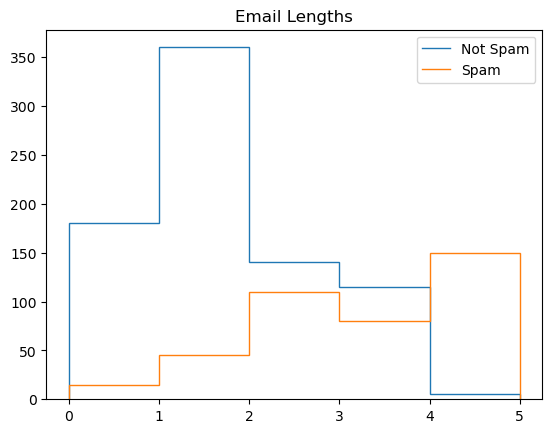

In [56]:
not_spam =np.array([180, 360, 140, 115, 5]) 
spam = np.array([15, 45, 110, 80, 150])
plt.stairs(not_spam, label="Not Spam")
plt.stairs(spam, label="Spam")
plt.legend()
plt.title("Email Lengths")


### Problem **2.2** 

State the procedure to do maximum likelihood (ML) estimation. Use it to determine **spam** or **not spam** labels for the three bins based on the data above:
- $400 \leq $ words
- $100 \leq 200$ words
- $200 \leq 300$ words

**[5 points]**

In [57]:
# P(spam|length) > P(~spam|length) iff P(length|spam) > P(length | ~spam)
# Therefore, >= 400 is likely to be spam
# 100 <= 200 words is likely to be not spam
# 200 <= 300 words is likely to be not spam
for i in range(len(spam)):
    print(f"P({i}00 <= words |spam) = {spam[i]/sum(spam)} P({i}00 <= words| ~spam) = {not_spam[i]/sum(not_spam)}")


P(000 <= words |spam) = 0.0375 P(000 <= words| ~spam) = 0.225
P(100 <= words |spam) = 0.1125 P(100 <= words| ~spam) = 0.45
P(200 <= words |spam) = 0.275 P(200 <= words| ~spam) = 0.175
P(300 <= words |spam) = 0.2 P(300 <= words| ~spam) = 0.14375
P(400 <= words |spam) = 0.375 P(400 <= words| ~spam) = 0.00625


### Problem **2.3** 

What is a good prior in this example for $P(spam)$ and $P(not\ spam)$? **[2 points]**

In [58]:
total = sum(spam) + sum(not_spam)
p_spam = sum(spam)/total
p_not_spam = sum(not_spam)/total

print(f"P(spam) = {p_spam}")
print(f"P(~spam) = {p_not_spam}")

P(spam) = 0.3333333333333333
P(~spam) = 0.6666666666666666


### Problem **2.4** 

Compute and draw the approximate curves to illustrate the posterior distributions $P(\text{spam}|\text{number of words})$ and $P(\text{not spam}|\text{number of words})$.

**[5 points]**

Text(0.5, 1.0, 'Posteriors')

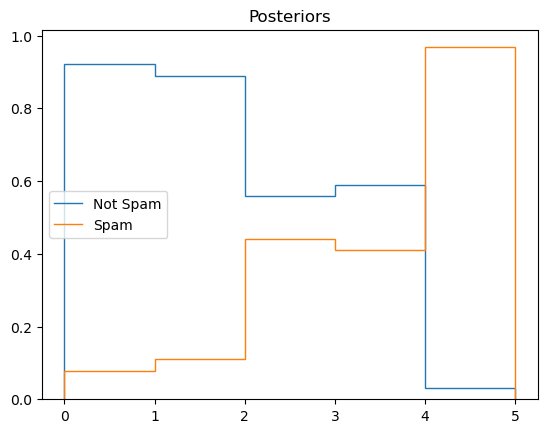

In [59]:
#P(spam|length) = P(length|spam)*P(spam)/P(length)
p_length = (spam + not_spam)/total
spam_posteriors = (spam/sum(spam))*p_spam/p_length
not_spam_posteriors = (not_spam/sum(not_spam))*p_not_spam/p_length

plt.stairs(not_spam_posteriors, label="Not Spam")
plt.stairs(spam_posteriors, label="Spam")
plt.legend()
plt.title("Posteriors")

### Problem **2.5** 

State the procedure to do maximum a posteriori (MAP) estimation. Use it to determine **spam** or **not spam** labels for the three bins:
- $400 \leq $ words
- $100 \leq 200$ words
- $200 \leq 300$ words

**[5 points]**

In [ ]:
# Now we just choose the category with the larger posteriors instead of the likelihood.
# From the previous graph we have that
# 400 <= is likely to be spam
# 100 <= 200 is likely to be not spam
# 200 <= 300 is likely to be not spam